## Imports

You have to modify the append folder to import the packages

In [1]:
import sys
#append the main folder so the script can find the packages
sys.path.append('/home/ABTLUS/victor.secco/github/') 
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from packages.eRDF import butter_lowpass_filter,DataProcessor
from packages.edp_processing import peak_calibration

## Calibration

A gold pattern is imported for calibration

The calculated calibration factor ds: 0.007451840848228294


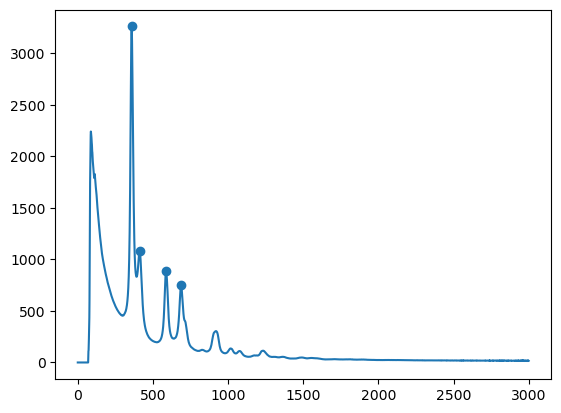

In [2]:
#gold peak calibration
from scipy.signal import find_peaks

au_path = os.getcwd() + '/data/IQ/Au.csv'

df_au = pd.read_csv(au_path, header = None)
data_au = df_au[0].values

peaks, _ = find_peaks(data_au, distance = 1, height=500)
calibration = peak_calibration(pixel_positions = peaks[2:6])

plt.plot(data_au)
plt.scatter(peaks[2:6], data_au[peaks[2:6]])
plt.show()

## Pair Distribution Function Calculation

The algorithm adjusts the theoretical scattering factors by optimizing a variable for the number of atoms $N$:

$S\left(Q\right) - 1 = \frac{I\left(Q\right) - \sum_{m}{N_{m} f_{m}^2\left(Q\right)}}{\sum_{m}{N_{m} f_{m}\left(Q\right)^2}}$

This optimization is constrained by the condition that the model intensity must equal the experimental intensity at the maximum value of $Q$, and the equation can be solved analytically.

### Fourier Transform and Reduced Pair Distribution Function (PDF)

The Fourier Transform (FT) is a mathematical analysis method that decomposes a signal into its constituent frequencies. High $Q$ frequencies are attenuated in the diffraction signal, so it is necessary to multiply the signal by $Q$ to extract these frequencies. After applying these corrections, the transform is used to obtain the so-called reduced Pair Distribution Function (PDF):

$G(r) = \frac{2}{\pi} \int_{Q_{min}}^{Q_{max}}{Q[S(Q)-1]}\sin{(Qr)}dQ = 4\pi r \rho_0 (g(r)- 1)$

### References

- [Electron Scattering factors](https://onlinelibrary.wiley.com/doi/abs/10.1107/S205327331401643X) 


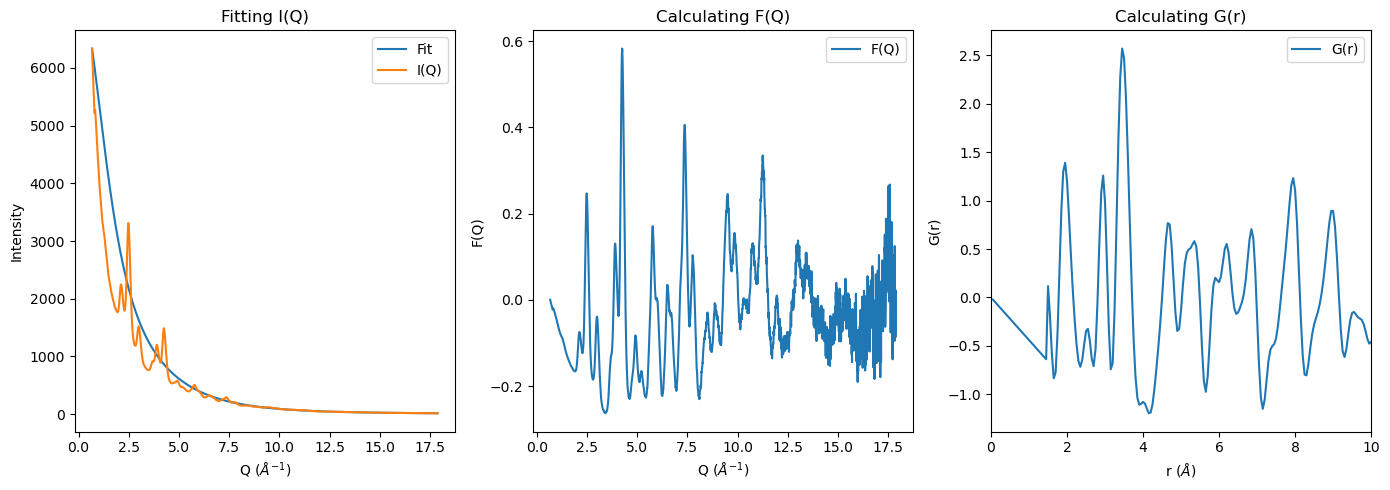

In [6]:
#Electron scattering factor table calculated by Lobato
lobato_path = os.path.dirname(os.getcwd()) + '/packages/Lobato_2014.txt'

ds = (calibration)/(2*math.pi)
nd = 1.4

Magnetite = {1: [26, 3], 2: [8, 4],}

file_name = os.getcwd() + '/data/IQ/Fe3O4_Oley_ROI1_2.csv'

df = pd.read_csv(file_name, header = None)

raw_data = df[0].values
start = int(raw_data.shape[0]*0.03)
end =  int(raw_data.shape[0]*0.8)

dp1 = DataProcessor(raw_data, lobato_path, start, end, ds, Magnetite, region = 0.2)
 
_iq = dp1.iq

#The damping is Q-dependent, and will kill high-Q signal if too high
_sq, _fq = dp1.calculate_SQ_PhiQ(_iq, damping = 0) 

#The low pass filter removes the noise frequencies on high Q
_fq_filtered = butter_lowpass_filter(_fq, fs = 50.0, cutoff = 2.0, order = 3)
_r, _Gr = dp1.calculate_Gr(_fq, rmax=80, dr=0.05)

#ad hoc low-r correction, nd is the number density of the material, which is multiplied by a scaling factor
_Gr, _ = dp1.low_r_correction(_Gr, nd*0.025, _r, r_cut = 1.5)

_inverse_fq = dp1.inverse_fourier_transform(_Gr[37:], _r[37:], _fq_filtered, nd)

_fq_normalized = (_fq_filtered-_fq_filtered.mean())/_fq_filtered.std()
_inverse_fq_normalized = (_inverse_fq-_inverse_fq.mean())/_inverse_fq.std()

dp1.plot_results(_fq, _r, _Gr)